In [1]:
using Pkg
Pkg.activate("..")
using Plots, PhasorNetworks, Random, DifferentialEquations
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

  Activating project at `~/code/PhasorNetworks.jl`


# Neural Networks

To wrap up this tutorial, we'll jump forward to demonstrate an application which incorporates similarity and bundling (superposition of many waves to create a similar output). 

Let's start by creating a simple bull's-eye dataset. We'll do this by importing the unit test which is run as part of the CI/CD for this package:

In [2]:
include("../test/data.jl")
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [3]:
args = Args(batchsize = 128, epochs = 25, use_cuda = false)
train_loader, test_loader = getdata(args)
x0, y0 = first(train_loader)

(Float32[0.34743592 -0.0940843 … 0.010800205 -0.039021626; 0.2676906 -0.34754997 … -0.016454937 0.03762827], Bool[0 0 … 1 1; 1 1 … 0 0])

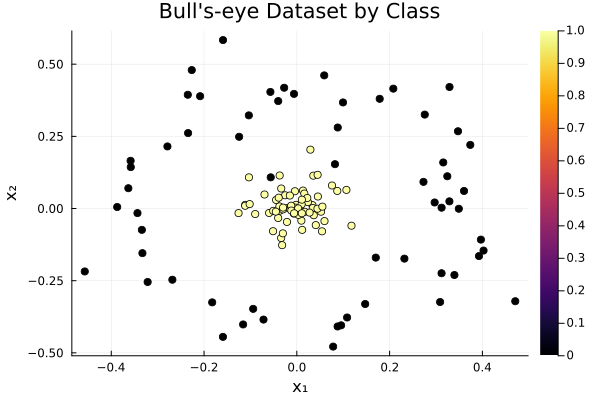

In [4]:
scatter(x0[1, :], x0[2, :], marker_z=y0[1,:], legend=false, colorbar=true, xlabel="x₁", ylabel="x₂", title="Bull's-eye Dataset by Class")

Now, let's tackle building a network architecture for this classification. It's a non-linear problem, so we'll need at least one hidden layer and a good activation function to solve this problem!

We'll describe what this network is doing at a high level: by converting each position to a phase value, it becomes a current pulse which drives an R&F neuron in the input layer. This produces a wave which propagates towards the second layer, and interferes with the waves arriving from all other input neurons - though this interference is attenuated per each arriving wave by a weight. 

By attenuating these waves, the phase produced by the second resonant neuron is selectively dependant on the inputs, and its phase (represented by spikes as its voltage reaches a maximum above a threshold) are communicated down to a final output layer. This output layer, in turn produces a phase.

In [5]:
p_model = Chain(x -> tanh.(x),  #convert onto the domain -1,1
            x -> x,  #placeholder layer
            PhasorDense(2 => 128, soft_angle),
            PhasorDense(128 => 2, soft_angle),
            )

Chain(
    layer_1 = WrappedFunction(#58),
    layer_2 = WrappedFunction(#59),
    layer_3 = PhasorDense(
        layer = Dense(2 => 128, use_bias=false),  # 256 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_4 = PhasorDense(
        layer = Dense(128 => 2, use_bias=false),  # 256 parameters
        bias = ComplexBias((2,)),       # 4 parameters
    ),
)         # Total: 772 parameters,
          #        plus 0 states.

Here, we initialize the weights and biases used in the model.

In [6]:
ps, st = Lux.setup(args.rng, p_model, )

((layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.3048801 1.1494075; -0.6522402 0.105043024; … ; 0.40384468 0.5826767; 0.057744846 -0.4485582],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_4 = (layer = (weight = Float32[0.06033335 -0.03069842 … 0.124181986 0.032054003; -0.12664655 0.049523786 … 0.0038915828 -0.08351208],), bias = (bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = (layer = NamedTuple(), bias = NamedTuple())))

Now, we define a loss function: this function look for one neuron with a phase that is 0.5 - in other words, $\pi/2$ or "orthogonal" to its neighbors in the output layer. The neuron closest to this phase is the predicted class.

In [7]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    loss = quadrature_loss(y_pred, y) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

Because the process of combining phases to produce an output is locally continuous, we can use AD to backprop through the error signal:

In [8]:
losses, ps_train, st_train = train(p_model, ps, st, train_loader, phasor_loss_function, args,)

[ Info: Training on CPU


(Any[0.93366313f0, 0.89587677f0, 0.8988076f0, 0.7153496f0, 0.59931135f0, 0.57967854f0, 0.4953514f0, 0.48155174f0, 0.43759948f0, 0.47470248f0  …  0.011273272f0, 0.007845005f0, 0.013026394f0, 0.0059429547f0, 0.0072380807f0, 0.02049481f0, 0.029120712f0, 0.0091761835f0, 0.015278109f0, 0.013020133f0], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.24575888 1.0578295; -0.73572445 -0.14793953; … ; 0.5054451 0.47160575; 0.026842676 -0.16340433],), bias = (bias_real = Float32[1.1762012, 0.87557113, 0.7984268, 0.98406905, 1.0556685, 0.7606234, 1.1133413, 0.7405888, 1.1943554, 0.87893003  …  1.0796282, 1.1723237, 1.1160387, 1.1955723, 0.864168, 0.9049485, 1.1290781, 0.4723695, 1.0896175, 1.0057203], bias_imag = Float32[-0.045363348, -0.32229167, -0.50999296, -0.49626064, -0.27087003, -0.13843624, -0.0704897, 0.35265282, 0.029022794, 0.26091754  …  0.39354426, 0.32527146, -0.09585119, -0.0355851, 0.19636317, 0.088754885, -0.05732129, 0.37308168, -0.03676251

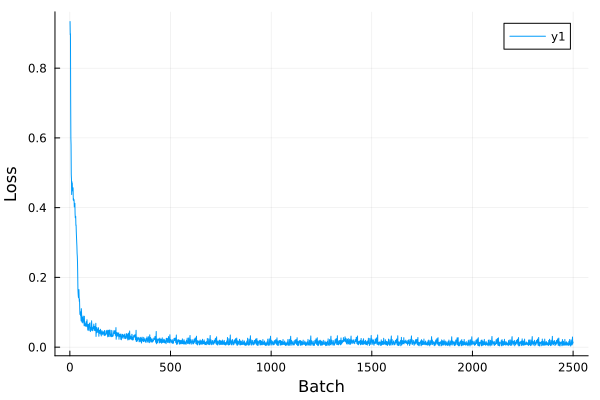

In [9]:
plot(losses)
xlabel!("Batch")
ylabel!("Loss")

Now, let's check the output accuracy on the withheld test set:

In [10]:
loss_and_accuracy(test_loader, p_model, ps_train , st_train, args)

(0.012116773f0, 0.98984375)

We've done all the calculations of phase thus far by using the "fast" method of computing with matrices of phases and trig identities. But we can also change the inputs to be spike trains and execute the network in the same way as we did with the similarity calculations!

In [11]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [12]:
repeats = 20
tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [13]:
spk_model = Chain(x -> tanh.(x),
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(2 => 128),
                    PhasorDense(128 => 2),)

Chain(
    layer_1 = WrappedFunction(#62),
    layer_2 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_3 = PhasorDense(
        layer = Dense(2 => 128, use_bias=false),  # 256 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_4 = PhasorDense(
        layer = Dense(128 => 2, use_bias=false),  # 256 parameters
        bias = ComplexBias((2,)),       # 4 parameters
    ),
)         # Total: 772 parameters,
          #        plus 0 states.

Let's look at the output for one batch:

In [14]:
y_spk, st_spk = spk_model(x0, ps_train, st_train)

(SpikingCall(Spike Train: (2, 128) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = (layer = NamedTuple(), bias = NamedTuple())))

In [15]:
spiking_phases = train_to_phase(y_spk);

We can inspect the phase of the output neuron's spikes for a single example: as we see below, after training the phase of the neuron successfully converges to 0.5 - indicating the class the incoming data point belongs to!

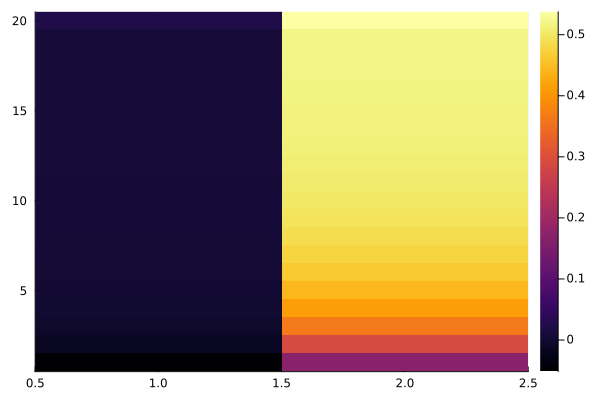

In [16]:
heatmap(spiking_phases[:,:,1])

# Conclusion

We've introduced a lot over the previous few notebooks - and there's still a lot we haven't touched on! 

To summarize:
* Phase values are a property of waves that can encode information
* These values can be stored in floating points or in a physical, oscillatory device
* By superimposing waves, we can calculate how close phase values are to one another by interference, or use the output to compute a new phase value
* This is enough to implement a simple neural network! It can work via analyzing phase values theoretically, or dynamically producing them via the interaction of resonate-and-fire neurons updated via differential equations and excited via spikes. 

This is just scratching the tip of the iceberg, and there's a lot of further room for exploration:
* More elaborate architectures of networks are possible - residual blocks can be implemented via rotation of phase values (binding) and encouraging layers of neurons to figure together (biases or feedback)
* When most layers of neurons fire together, most of the information in spikes is redundant. By using cross-neuron inhibition to drop out spikes at the busiest times, you can reduce overhead without losing accuracy! This is also similar to the excitatory-inhibitory balance observed in neural tissue.
* Similarity and binding can also be used to implement attention-like architectures, as well as associative memories!
* By customizing the differential equation updates inside our R&F neurons, we can simulate how actual, physical devices work in these networks and characterize their performance. 
* We can extend to larger systems and networks utilizing GPUs! The network above runs on GPUs - even in spiking mode. 

There's also a lot of work to be done in the future, such as:
* Can we use banks of neurons with different frequencies? How can this distribute information across time?
* Can we construct networks of grid-cell inspired position encoding modules? This is possible with fractional binding, where rotation of one symbol by another is done fractionally. 
* Can attention mechanisms based on similarity reach the same capabilities as those in traditional AI?
* What are the best hardware candidates for R&F neurons? 
* What are the best encoding strategies for real values to phase?
* What hardware can be used to effectively integrate R&F neurons into digital systems? 

Thanks for participating in this workshop - I hope this tutorial will motivate you to keep exploring this approach and address some of the questions above or entirely new ones!
